In [290]:
import io
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, StackingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.kernel_ridge import KernelRidge

In [291]:
historical_weather = pd.read_csv(r"C:\0A___________________________________\Predictor 1.0\historical_weather.csv")
test_data = pd.read_csv(r"C:\0A___________________________________\Predictor 1.0\submission_key.csv")

In [292]:
historical_weather.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,C001,2014-01-01,6.6,-1.4,11.6,NaN,NaN,168.0,6.2
1,C001,2014-01-02,9.3,6.3,13.3,NaN,NaN,155.0,10.0
2,C001,2014-01-03,7.6,1.9,14.0,NaN,NaN,NaN,5.8
3,C001,2014-01-04,7.6,3.9,13.3,NaN,NaN,291.0,11.3
4,C001,2014-01-05,8.6,0.5,16.9,NaN,NaN,NaN,5.0


In [293]:
historical_weather.shape

(182338, 9)

In [294]:
test_data.shape

(700, 3)

In [295]:
historical_weather.describe()

,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh
count,181114.000000,176452.000000,174845.000000,112594.000000,12238.000000,146944.000000,159866.000000
mean,19.137516,14.627775,23.887261,3.679964,342.481696,175.650289,11.281875
std,9.902722,10.004998,10.446670,11.294167,1020.265388,105.435150,6.132884
min,-34.700000,-43.800000,-28.500000,0.000000,0.000000,0.000000,0.000000
25%,12.400000,7.500000,17.100000,0.000000,0.000000,83.000000,7.200000
50%,21.400000,16.200000,27.000000,0.000000,10.000000,178.000000,9.900000
75%,27.100000,23.300000,31.500000,2.300000,140.000000,266.000000,14.000000
max,41.900000,38.900000,49.100000,496.100000,7140.000000,360.000000,80.000000


In [296]:
historical_weather.dtypes[historical_weather.dtypes != 'object']

avg_temp_c            float64
min_temp_c            float64
max_temp_c            float64
precipitation_mm      float64
snow_depth_mm         float64
avg_wind_dir_deg      float64
avg_wind_speed_kmh    float64
dtype: object

In [297]:
historical_weather.dtypes[historical_weather.dtypes == 'object']

city_id    object
date       object
dtype: object

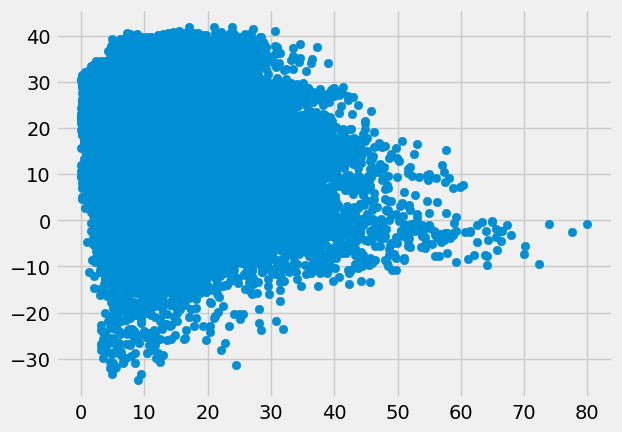

In [298]:
plt.scatter(x='avg_wind_speed_kmh', y='avg_temp_c', data=historical_weather)

In [299]:
#Missing value handling

In [300]:
pd.DataFrame(historical_weather.isnull().sum().sort_values(ascending=False)).head(20)

,0
snow_depth_mm,170100
precipitation_mm,69744
avg_wind_dir_deg,35394
avg_wind_speed_kmh,22472
max_temp_c,7493
min_temp_c,5886
avg_temp_c,1224
city_id,0
date,0


In [301]:
##Drop snow_depth_mm column

In [302]:
historical_weather.drop(columns=['snow_depth_mm'], inplace=True)

In [303]:
# num_cols = historical_weather.select_dtypes(include=['int64', 'float64']).columns

In [304]:
# num_pipeline = Pipeline(steps=[
#     ('impute', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])

In [305]:
# col_trans = ColumnTransformer(transformers=[
#     ('num_p', num_pipeline, num_cols)
#     ],
#     remainder='passthrough', 
#     n_jobs=-1)

In [306]:
#  pipeline = Pipeline(steps=[
#     ('preprocessing', col_trans)
# ])

In [307]:
# preprocessed = pipeline.fit_transform(historical_weather)

In [308]:
# historical_weather = pd.DataFrame(historical_weather)

In [309]:
#Feature Engineering

In [310]:
print(type(historical_weather))

<class 'pandas.core.frame.DataFrame'>


In [311]:
# historical_weather = historical_weather.drop(columns=['precipitation_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'max_temp_c', 'min_temp_c'])

In [312]:
historical_weather['date'] = pd.to_datetime(historical_weather['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

In [313]:
historical_weather['city_id'] = historical_weather['city_id'].str.extract('(\d+)').astype(int)
test_data['city_id'] = test_data['city_id'].str.extract('(\d+)').astype(int)

historical_df = historical_weather.copy()

In [314]:
historical_weather['city_id'].unique()

array([  1,   2,   3,   4,   5,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  20,  22,  23,  24,  25,  27,  28,  29,  30,
        31,  33,  34,  35,  36,  37,  38,  39,  40,  42,  43,  44,  45,
        46,  47,  48,  49,  51,  53,  54,  55,  56,  57,  58,  59,  61,
        62,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  76,
        77,  78,  79,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112])

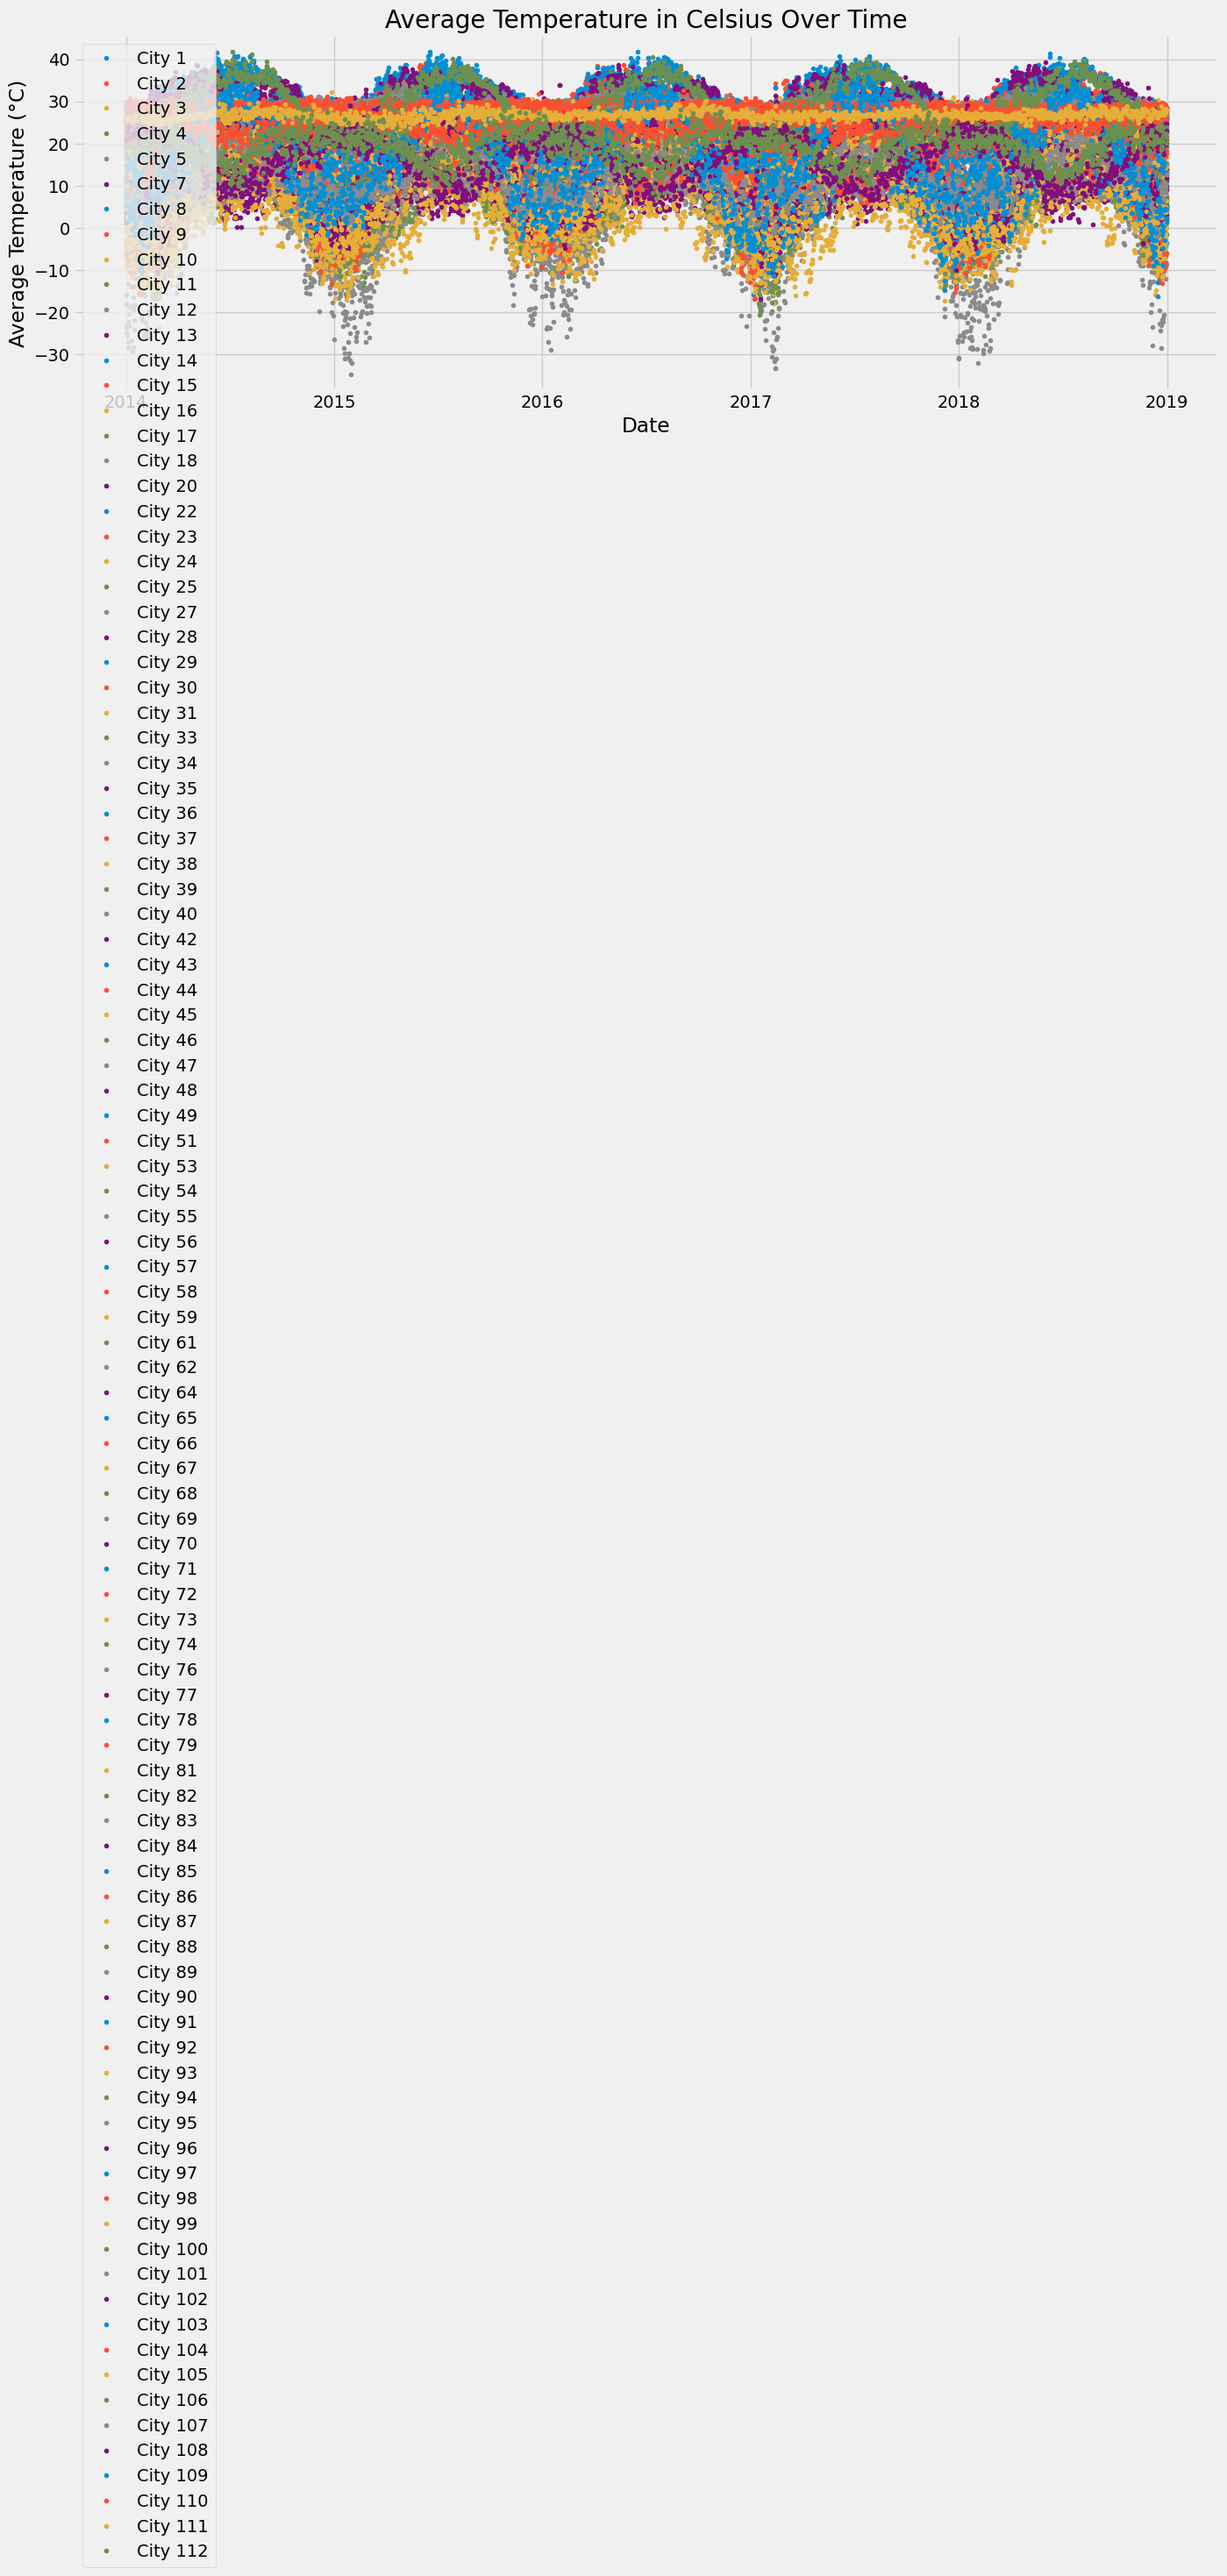

In [315]:
plt.figure(figsize=(15, 5))
for city in historical_weather['city_id'].unique():
    city_data = historical_weather[historical_weather['city_id'] == city]
    plt.plot(city_data['date'], city_data['avg_temp_c'], '.', label=f'City {city}')

plt.title('Average Temperature in Celsius Over Time')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.legend(loc='best')
plt.show()

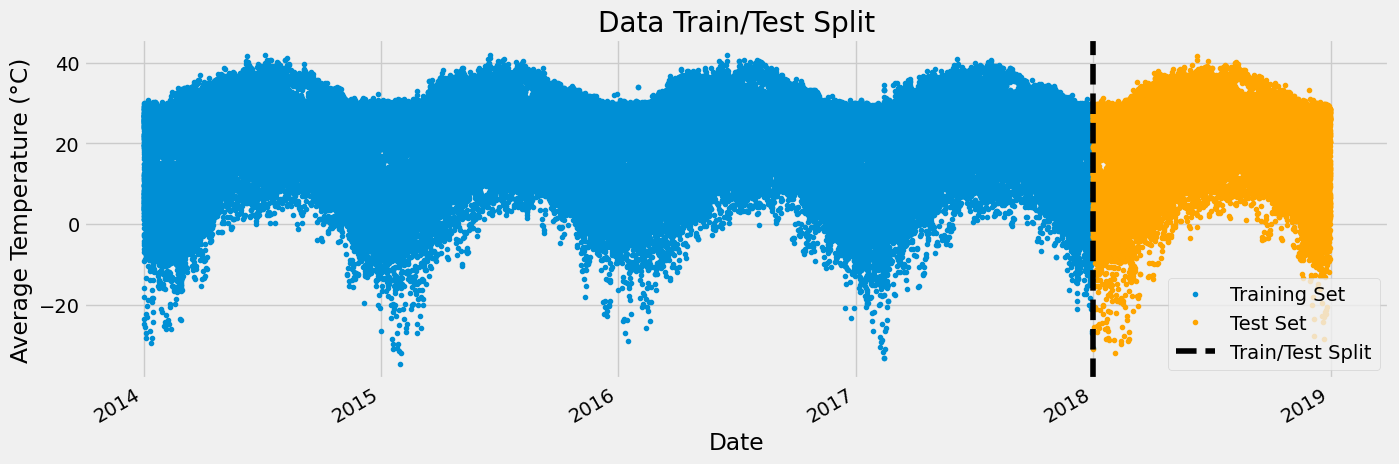

In [316]:
train = historical_weather.loc[historical_weather['date'] < '01-01-2018']
test = historical_weather.loc[historical_weather['date'] >= '01-01-2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(x='date', y='avg_temp_c', ax=ax, label='Training Set', style='.')
test.plot(x='date', y='avg_temp_c', ax=ax, label='Test Set', style='.', color='orange')
ax.axvline(pd.to_datetime('01-01-2018'), color='black', ls='--')
ax.set_title('Data Train/Test Split')
ax.set_xlabel('Date')
ax.set_ylabel('Average Temperature (°C)')
ax.legend(['Training Set', 'Test Set', 'Train/Test Split'])

plt.show()

In [317]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    return df

# historical_weather = create_features(historical_weather)

In [318]:
historical_weather.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,1,2014-01-01,6.6,-1.4,11.6,NaN,168.0,6.2
1,1,2014-01-02,9.3,6.3,13.3,NaN,155.0,10.0
2,1,2014-01-03,7.6,1.9,14.0,NaN,NaN,5.8
3,1,2014-01-04,7.6,3.9,13.3,NaN,291.0,11.3
4,1,2014-01-05,8.6,0.5,16.9,NaN,NaN,5.0


In [319]:
# historical_weather = historical_weather.drop(columns=['precipitation_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'max_temp_c', 'min_temp_c'])

In [320]:
historical_weather.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,1,2014-01-01,6.6,-1.4,11.6,NaN,168.0,6.2
1,1,2014-01-02,9.3,6.3,13.3,NaN,155.0,10.0
2,1,2014-01-03,7.6,1.9,14.0,NaN,NaN,5.8
3,1,2014-01-04,7.6,3.9,13.3,NaN,291.0,11.3
4,1,2014-01-05,8.6,0.5,16.9,NaN,NaN,5.0


In [321]:
#missing values handling

In [322]:
imputer = SimpleImputer(strategy='mean')

In [323]:
historical_weather[['avg_temp_c','precipitation_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'max_temp_c', 'min_temp_c']] = imputer.fit_transform(historical_weather[[
    'avg_temp_c','precipitation_mm', 'avg_wind_dir_deg', 'avg_wind_speed_kmh', 'max_temp_c', 'min_temp_c']])


In [324]:
# city_means = historical_weather.groupby('city_id').mean().reset_index()
# test_data = pd.merge(test_data, city_means, on='city_id', suffixes=('', '_mean'))
# test_data = test_data.drop(columns=['date_mean'])

In [325]:
last_date = historical_weather.groupby('city_id')['date'].max().reset_index()
last_date.columns = ['city_id', 'last_date']

# Merge last date with historical data to create future features
test_data = pd.merge(test_data, last_date, on='city_id', how='left')
test_data = pd.merge(test_data, historical_weather, left_on=['city_id', 'last_date'], right_on=['city_id', 'date'], suffixes=('', '_last'))
test_data = test_data.drop(columns=['last_date','date_last'])

In [326]:
test_data

,submission_ID,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh
0,1,1,2019-01-01,11.8,6.0,18.0,1.7,164.0,5.7
1,2,1,2019-01-02,11.8,6.0,18.0,1.7,164.0,5.7
2,3,1,2019-01-03,11.8,6.0,18.0,1.7,164.0,5.7
3,4,1,2019-01-04,11.8,6.0,18.0,1.7,164.0,5.7
4,5,1,2019-01-05,11.8,6.0,18.0,1.7,164.0,5.7
...,...,...,...,...,...,...,...,...,...
695,696,112,2019-01-03,20.2,17.1,25.0,17.5,103.0,12.6
696,697,112,2019-01-04,20.2,17.1,25.0,17.5,103.0,12.6
697,698,112,2019-01-05,20.2,17.1,25.0,17.5,103.0,12.6
698,699,112,2019-01-06,20.2,17.1,25.0,17.5,103.0,12.6


In [327]:
historical_weather = create_features(historical_weather)

In [328]:
historical_weather

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,1,2014-01-01,6.6,-1.4,11.6,3.679964,168.000000,6.2,2,1,1,2014,1,1,1
1,1,2014-01-02,9.3,6.3,13.3,3.679964,155.000000,10.0,3,1,1,2014,2,2,1
2,1,2014-01-03,7.6,1.9,14.0,3.679964,175.650289,5.8,4,1,1,2014,3,3,1
3,1,2014-01-04,7.6,3.9,13.3,3.679964,291.000000,11.3,5,1,1,2014,4,4,1
4,1,2014-01-05,8.6,0.5,16.9,3.679964,175.650289,5.0,6,1,1,2014,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182333,112,2018-12-27,22.0,15.9,27.9,0.000000,100.000000,13.2,3,4,12,2018,361,27,52
182334,112,2018-12-28,21.9,14.9,28.2,0.000000,91.000000,12.6,4,4,12,2018,362,28,52
182335,112,2018-12-29,22.4,16.3,28.2,0.000000,61.000000,14.2,5,4,12,2018,363,29,52
182336,112,2018-12-30,21.6,18.5,26.6,1.600000,70.000000,17.0,6,4,12,2018,364,30,52


In [329]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
# historical_weather = historical_weather.sort_index()

In [330]:
historical_weather['year'].unique()

array([2014, 2015, 2016, 2017, 2018])

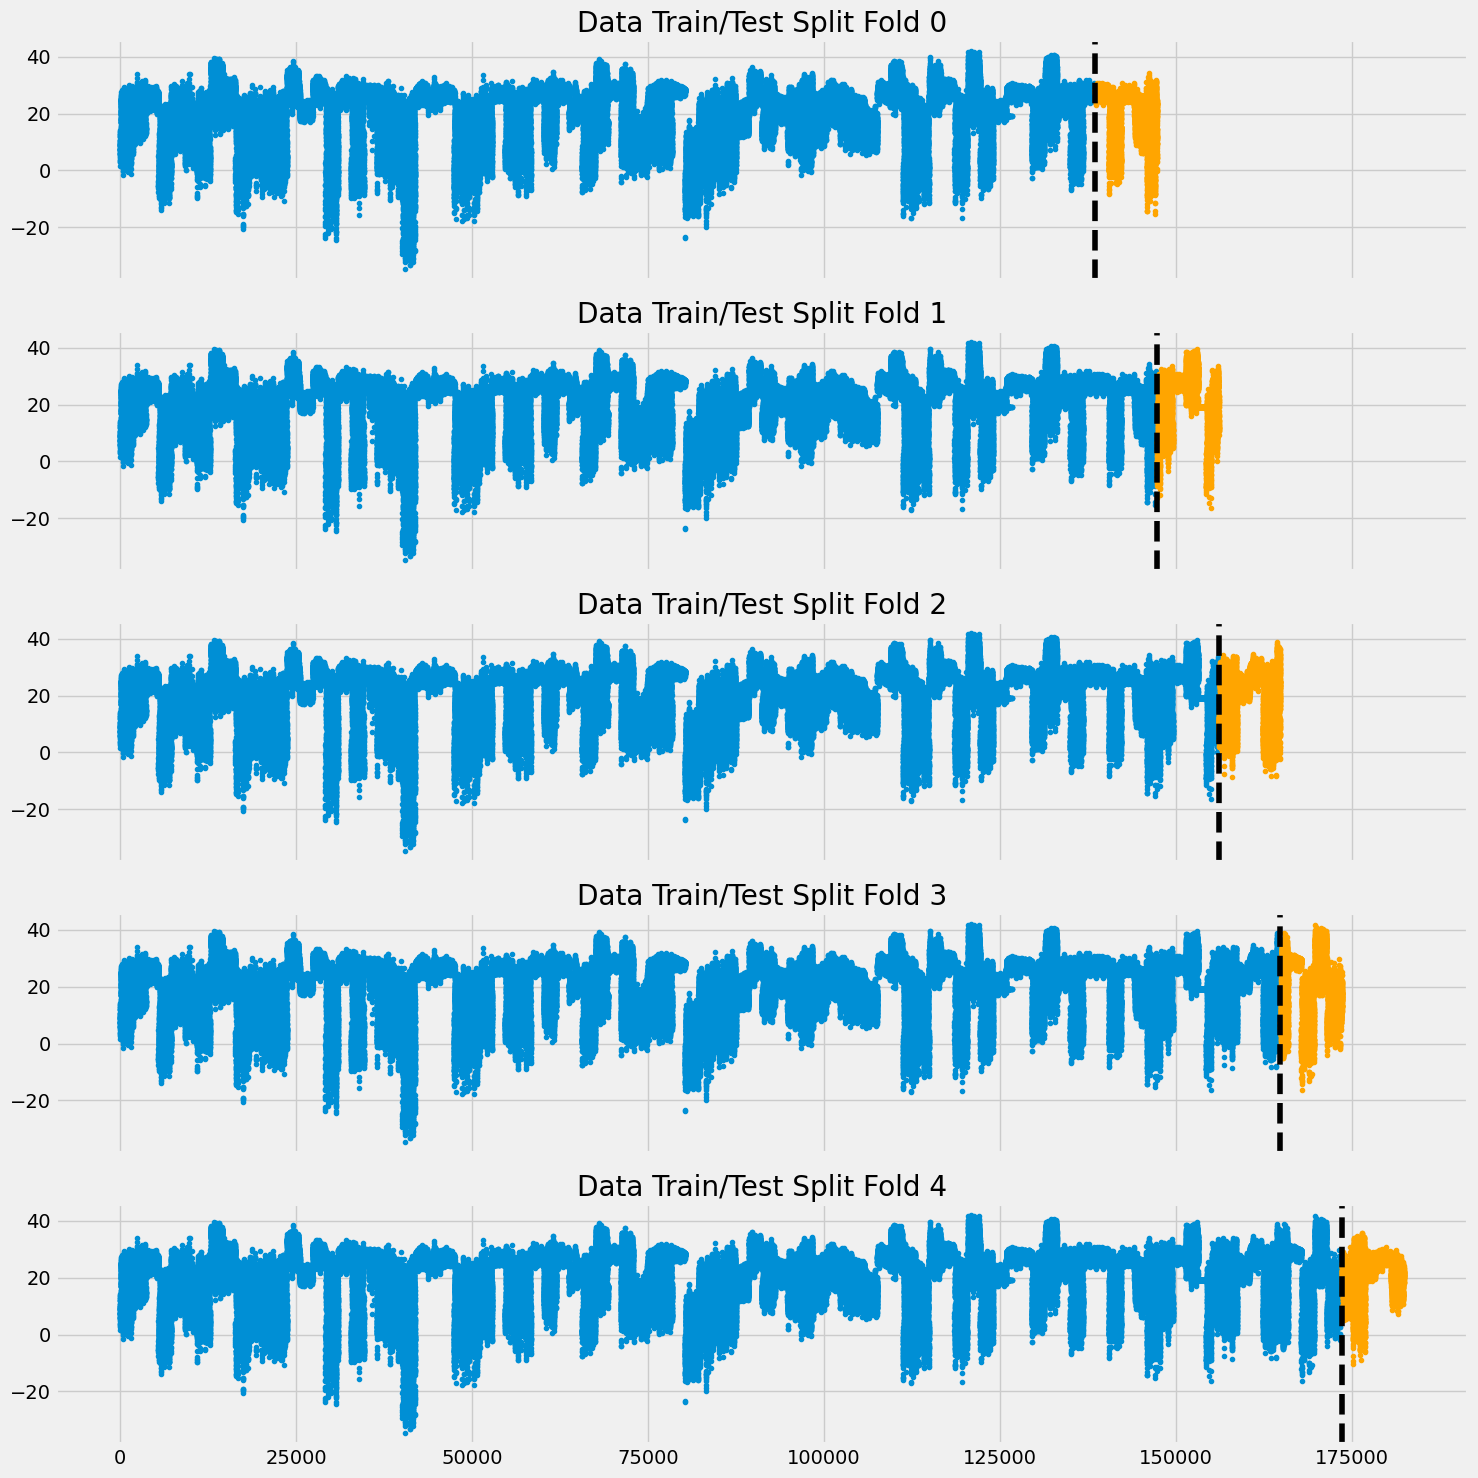

In [331]:
historical_weather['date'] = pd.to_datetime(historical_weather['date'])
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(historical_weather):
    train = historical_weather.iloc[train_idx]
    test = historical_weather.iloc[val_idx]
    train['avg_temp_c'].plot(x='date',ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}',style='.')
    test['avg_temp_c'].plot(x='date',ax=axs[fold],
                         label='Test Set',style='.',color='orange')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.tight_layout()
plt.show()

In [332]:
# historical_weather = historical_weather.drop(columns=['date'])

In [333]:
historical_weather

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
0,1,2014-01-01,6.6,-1.4,11.6,3.679964,168.000000,6.2,2,1,1,2014,1,1,1
1,1,2014-01-02,9.3,6.3,13.3,3.679964,155.000000,10.0,3,1,1,2014,2,2,1
2,1,2014-01-03,7.6,1.9,14.0,3.679964,175.650289,5.8,4,1,1,2014,3,3,1
3,1,2014-01-04,7.6,3.9,13.3,3.679964,291.000000,11.3,5,1,1,2014,4,4,1
4,1,2014-01-05,8.6,0.5,16.9,3.679964,175.650289,5.0,6,1,1,2014,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182333,112,2018-12-27,22.0,15.9,27.9,0.000000,100.000000,13.2,3,4,12,2018,361,27,52
182334,112,2018-12-28,21.9,14.9,28.2,0.000000,91.000000,12.6,4,4,12,2018,362,28,52
182335,112,2018-12-29,22.4,16.3,28.2,0.000000,61.000000,14.2,5,4,12,2018,363,29,52
182336,112,2018-12-30,21.6,18.5,26.6,1.600000,70.000000,17.0,6,4,12,2018,364,30,52


In [334]:
def create_lag_features(df, lags, cols):
    for col in cols:
        for lag in lags:
            df[f'{col}_lag_{lag}'] = df.groupby('city_id')[col].shift(lag)
    return df

In [335]:
lag_features = ['avg_temp_c']
lags = [1, 2, 3, 4, 5, 6, 7]  # 1-day, 2-day, 3-day, 7-day, 14-day, and 30-day lags
historical_weather = create_lag_features(historical_weather, lags, lag_features)

In [336]:
historical_weather.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,dayofweek,quarter,...,dayofyear,dayofmonth,weekofyear,avg_temp_c_lag_1,avg_temp_c_lag_2,avg_temp_c_lag_3,avg_temp_c_lag_4,avg_temp_c_lag_5,avg_temp_c_lag_6,avg_temp_c_lag_7
0,1,2014-01-01,6.6,-1.4,11.6,3.679964,168.000000,6.2,2,1,...,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2014-01-02,9.3,6.3,13.3,3.679964,155.000000,10.0,3,1,...,2,2,1,6.6,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2014-01-03,7.6,1.9,14.0,3.679964,175.650289,5.8,4,1,...,3,3,1,9.3,6.6,NaN,NaN,NaN,NaN,NaN
3,1,2014-01-04,7.6,3.9,13.3,3.679964,291.000000,11.3,5,1,...,4,4,1,7.6,9.3,6.6,NaN,NaN,NaN,NaN
4,1,2014-01-05,8.6,0.5,16.9,3.679964,175.650289,5.0,6,1,...,5,5,1,7.6,7.6,9.3,6.6,NaN,NaN,NaN


In [337]:
# historical_weather = historical_weather.fillna(0.0)

In [338]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
historical_weather = historical_weather.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(historical_weather):
    train = historical_weather.iloc[train_idx]
    test = historical_weather.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['city_id','min_temp_c','max_temp_c','precipitation_mm','avg_wind_dir_deg','avg_wind_speed_kmh','dayofweek', 'quarter', 'month','year', 'dayofyear','dayofmonth','weekofyear','avg_temp_c_lag_1','avg_temp_c_lag_2',
                'avg_temp_c_lag_3','avg_temp_c_lag_4','avg_temp_c_lag_5','avg_temp_c_lag_6','avg_temp_c_lag_7']
    TARGET = 'avg_temp_c'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=50000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:20.61018	validation_1-rmse:21.50553


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:35:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:7.75231	validation_1-rmse:8.03249
[200]	validation_0-rmse:3.11783	validation_1-rmse:3.23379
[300]	validation_0-rmse:1.60635	validation_1-rmse:1.80011
[400]	validation_0-rmse:1.22911	validation_1-rmse:1.49635
[500]	validation_0-rmse:1.14342	validation_1-rmse:1.42976
[600]	validation_0-rmse:1.11809	validation_1-rmse:1.41779
[700]	validation_0-rmse:1.10535	validation_1-rmse:1.41052
[800]	validation_0-rmse:1.09368	validation_1-rmse:1.40344
[900]	validation_0-rmse:1.07716	validation_1-rmse:1.38537
[1000]	validation_0-rmse:1.06094	validation_1-rmse:1.36436
[1100]	validation_0-rmse:1.04670	validation_1-rmse:1.34837
[1200]	validation_0-rmse:1.03575	validation_1-rmse:1.33790
[1300]	validation_0-rmse:1.02498	validation_1-rmse:1.32254
[1400]	validation_0-rmse:1.01475	validation_1-rmse:1.31374
[1500]	validation_0-rmse:1.00551	validation_1-rmse:1.30213
[1600]	validation_0-rmse:0.99727	validation_1-rmse:1.29429
[1700]	validation_0-rmse:0.98965	validation_1-rmse:1.28638
[1800]

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:35:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:7.77669	validation_1-rmse:8.62648
[200]	validation_0-rmse:3.13507	validation_1-rmse:3.81800
[300]	validation_0-rmse:1.62827	validation_1-rmse:2.46390
[400]	validation_0-rmse:1.25484	validation_1-rmse:2.21394
[451]	validation_0-rmse:1.19781	validation_1-rmse:2.23994
[0]	validation_0-rmse:20.77793	validation_1-rmse:21.37760


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:35:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:7.81712	validation_1-rmse:7.99932
[200]	validation_0-rmse:3.16498	validation_1-rmse:3.25902
[300]	validation_0-rmse:1.66487	validation_1-rmse:1.73361
[400]	validation_0-rmse:1.29475	validation_1-rmse:1.38723
[500]	validation_0-rmse:1.20880	validation_1-rmse:1.32113
[600]	validation_0-rmse:1.17880	validation_1-rmse:1.29897
[700]	validation_0-rmse:1.16138	validation_1-rmse:1.28185
[800]	validation_0-rmse:1.14949	validation_1-rmse:1.26724
[900]	validation_0-rmse:1.13690	validation_1-rmse:1.25354
[1000]	validation_0-rmse:1.12178	validation_1-rmse:1.23720
[1100]	validation_0-rmse:1.10810	validation_1-rmse:1.22260
[1200]	validation_0-rmse:1.09351	validation_1-rmse:1.21325
[1300]	validation_0-rmse:1.08069	validation_1-rmse:1.20364
[1400]	validation_0-rmse:1.06928	validation_1-rmse:1.19449
[1500]	validation_0-rmse:1.06002	validation_1-rmse:1.19110
[1600]	validation_0-rmse:1.05088	validation_1-rmse:1.18673
[1700]	validation_0-rmse:1.04339	validation_1-rmse:1.18392
[1740]

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:36:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:7.83006	validation_1-rmse:8.35752
[200]	validation_0-rmse:3.17427	validation_1-rmse:3.45952
[300]	validation_0-rmse:1.67925	validation_1-rmse:1.74029
[400]	validation_0-rmse:1.31174	validation_1-rmse:1.24774
[500]	validation_0-rmse:1.22787	validation_1-rmse:1.12899
[600]	validation_0-rmse:1.19959	validation_1-rmse:1.09266
[700]	validation_0-rmse:1.18464	validation_1-rmse:1.07817
[800]	validation_0-rmse:1.17029	validation_1-rmse:1.07052
[900]	validation_0-rmse:1.15827	validation_1-rmse:1.06470
[1000]	validation_0-rmse:1.14044	validation_1-rmse:1.04797
[1100]	validation_0-rmse:1.12468	validation_1-rmse:1.03187
[1200]	validation_0-rmse:1.10668	validation_1-rmse:1.01379
[1300]	validation_0-rmse:1.09240	validation_1-rmse:0.99858
[1400]	validation_0-rmse:1.08111	validation_1-rmse:0.98641
[1500]	validation_0-rmse:1.07134	validation_1-rmse:0.97636
[1600]	validation_0-rmse:1.06288	validation_1-rmse:0.96929
[1700]	validation_0-rmse:1.05593	validation_1-rmse:0.96299
[1800]

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:36:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:7.84537	validation_1-rmse:7.87399
[200]	validation_0-rmse:3.17653	validation_1-rmse:3.13489
[300]	validation_0-rmse:1.67409	validation_1-rmse:1.67578
[400]	validation_0-rmse:1.30268	validation_1-rmse:1.33690
[500]	validation_0-rmse:1.21796	validation_1-rmse:1.26265
[600]	validation_0-rmse:1.18989	validation_1-rmse:1.24058
[700]	validation_0-rmse:1.17585	validation_1-rmse:1.23135
[800]	validation_0-rmse:1.16191	validation_1-rmse:1.21848
[900]	validation_0-rmse:1.14983	validation_1-rmse:1.20839
[1000]	validation_0-rmse:1.12986	validation_1-rmse:1.18536
[1100]	validation_0-rmse:1.11094	validation_1-rmse:1.16459
[1200]	validation_0-rmse:1.09651	validation_1-rmse:1.15069
[1300]	validation_0-rmse:1.08474	validation_1-rmse:1.13708
[1400]	validation_0-rmse:1.07439	validation_1-rmse:1.12705
[1500]	validation_0-rmse:1.06511	validation_1-rmse:1.11784
[1600]	validation_0-rmse:1.05733	validation_1-rmse:1.11055
[1700]	validation_0-rmse:1.04896	validation_1-rmse:1.10257
[1800]

In [339]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 1.3193
Fold scores:[1.2538118757078045, 2.2119743225124253, 1.1824889329879225, 0.9063624455232231, 1.0420385686343787]


In [340]:
# Retrain on all data
historical_weather = create_features(historical_weather)

FEATURES = ['city_id','min_temp_c','max_temp_c','precipitation_mm','avg_wind_dir_deg','avg_wind_speed_kmh','dayofweek', 'quarter', 'month','year', 'dayofyear','dayofmonth','weekofyear','avg_temp_c_lag_1','avg_temp_c_lag_2',
                'avg_temp_c_lag_3','avg_temp_c_lag_4','avg_temp_c_lag_5','avg_temp_c_lag_6','avg_temp_c_lag_7']
TARGET = 'avg_temp_c'

X_all = historical_weather[FEATURES]
y_all = historical_weather[TARGET]

reg = XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=50000,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:20.88136


c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [09:36:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:7.85358
[200]	validation_0-rmse:3.17833
[300]	validation_0-rmse:1.67206
[400]	validation_0-rmse:1.30021
[500]	validation_0-rmse:1.21506
[600]	validation_0-rmse:1.18702
[700]	validation_0-rmse:1.17108
[800]	validation_0-rmse:1.15898
[900]	validation_0-rmse:1.14438
[1000]	validation_0-rmse:1.12663
[1100]	validation_0-rmse:1.11059
[1200]	validation_0-rmse:1.09923
[1300]	validation_0-rmse:1.08552
[1400]	validation_0-rmse:1.07539
[1500]	validation_0-rmse:1.06633
[1600]	validation_0-rmse:1.05817
[1700]	validation_0-rmse:1.05038
[1800]	validation_0-rmse:1.04351
[1900]	validation_0-rmse:1.03742
[2000]	validation_0-rmse:1.03128
[2100]	validation_0-rmse:1.02651
[2200]	validation_0-rmse:1.02185
[2300]	validation_0-rmse:1.01736
[2400]	validation_0-rmse:1.01322
[2500]	validation_0-rmse:1.00917
[2600]	validation_0-rmse:1.00529
[2700]	validation_0-rmse:1.00161
[2800]	validation_0-rmse:0.99833
[2900]	validation_0-rmse:0.99477
[3000]	validation_0-rmse:0.99166
[3100]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [341]:
test_data['isFuture'] = True
historical_df['isFuture'] = False
df_and_future = pd.concat([historical_df, test_data])
df_and_future = create_features(df_and_future)
lag_features = ['avg_temp_c']
lags = [1, 2, 3, 4, 5, 6, 7] 
df_and_future = create_lag_features(df_and_future,lags,lag_features)


In [342]:
historical_weather

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,dayofweek,quarter,...,dayofyear,dayofmonth,weekofyear,avg_temp_c_lag_1,avg_temp_c_lag_2,avg_temp_c_lag_3,avg_temp_c_lag_4,avg_temp_c_lag_5,avg_temp_c_lag_6,avg_temp_c_lag_7
0,1,2014-01-01,6.6,-1.4,11.6,3.679964,168.000000,6.2,2,1,...,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2014-01-02,9.3,6.3,13.3,3.679964,155.000000,10.0,3,1,...,2,2,1,6.6,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2014-01-03,7.6,1.9,14.0,3.679964,175.650289,5.8,4,1,...,3,3,1,9.3,6.6,NaN,NaN,NaN,NaN,NaN
3,1,2014-01-04,7.6,3.9,13.3,3.679964,291.000000,11.3,5,1,...,4,4,1,7.6,9.3,6.6,NaN,NaN,NaN,NaN
4,1,2014-01-05,8.6,0.5,16.9,3.679964,175.650289,5.0,6,1,...,5,5,1,7.6,7.6,9.3,6.6,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182333,112,2018-12-27,22.0,15.9,27.9,0.000000,100.000000,13.2,3,4,...,361,27,52,22.3,21.9,20.6,19.3,18.5,19.2,21.0
182334,112,2018-12-28,21.9,14.9,28.2,0.000000,91.000000,12.6,4,4,...,362,28,52,22.0,22.3,21.9,20.6,19.3,18.5,19.2
182335,112,2018-12-29,22.4,16.3,28.2,0.000000,61.000000,14.2,5,4,...,363,29,52,21.9,22.0,22.3,21.9,20.6,19.3,18.5
182336,112,2018-12-30,21.6,18.5,26.6,1.600000,70.000000,17.0,6,4,...,364,30,52,22.4,21.9,22.0,22.3,21.9,20.6,19.3


In [343]:
df_and_future

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,isFuture,submission_ID,...,dayofyear,dayofmonth,weekofyear,avg_temp_c_lag_1,avg_temp_c_lag_2,avg_temp_c_lag_3,avg_temp_c_lag_4,avg_temp_c_lag_5,avg_temp_c_lag_6,avg_temp_c_lag_7
0,1,2014-01-01,6.6,-1.4,11.6,NaN,168.0,6.2,False,NaN,...,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2014-01-02,9.3,6.3,13.3,NaN,155.0,10.0,False,NaN,...,2,2,1,6.6,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2014-01-03,7.6,1.9,14.0,NaN,NaN,5.8,False,NaN,...,3,3,1,9.3,6.6,NaN,NaN,NaN,NaN,NaN
3,1,2014-01-04,7.6,3.9,13.3,NaN,291.0,11.3,False,NaN,...,4,4,1,7.6,9.3,6.6,NaN,NaN,NaN,NaN
4,1,2014-01-05,8.6,0.5,16.9,NaN,NaN,5.0,False,NaN,...,5,5,1,7.6,7.6,9.3,6.6,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,112,2019-01-03,20.2,17.1,25.0,17.5,103.0,12.6,True,696.0,...,3,3,1,20.2,20.2,20.2,21.6,22.4,21.9,22.0
696,112,2019-01-04,20.2,17.1,25.0,17.5,103.0,12.6,True,697.0,...,4,4,1,20.2,20.2,20.2,20.2,21.6,22.4,21.9
697,112,2019-01-05,20.2,17.1,25.0,17.5,103.0,12.6,True,698.0,...,5,5,1,20.2,20.2,20.2,20.2,20.2,21.6,22.4
698,112,2019-01-06,20.2,17.1,25.0,17.5,103.0,12.6,True,699.0,...,6,6,1,20.2,20.2,20.2,20.2,20.2,20.2,21.6


In [344]:
future_w_features = df_and_future.query('isFuture').copy()

In [345]:
features = ['submission_ID','city_id','min_temp_c','max_temp_c','precipitation_mm','avg_wind_dir_deg','avg_wind_speed_kmh','dayofweek', 'quarter', 'month','year', 'dayofyear','dayofmonth','weekofyear','avg_temp_c_lag_1','avg_temp_c_lag_2',
                'avg_temp_c_lag_3','avg_temp_c_lag_4','avg_temp_c_lag_5','avg_temp_c_lag_6','avg_temp_c_lag_7']
future_w_features  = future_w_features[features].sort_values(by='submission_ID', ascending=True).drop(columns=['submission_ID'])

future_w_features

,city_id,min_temp_c,max_temp_c,precipitation_mm,avg_wind_dir_deg,avg_wind_speed_kmh,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,avg_temp_c_lag_1,avg_temp_c_lag_2,avg_temp_c_lag_3,avg_temp_c_lag_4,avg_temp_c_lag_5,avg_temp_c_lag_6,avg_temp_c_lag_7
0,1,6.0,18.0,1.7,164.0,5.7,1,1,1,2019,1,1,1,11.8,10.7,8.9,10.1,9.7,9.4,9.0
1,1,6.0,18.0,1.7,164.0,5.7,2,1,1,2019,2,2,1,11.8,11.8,10.7,8.9,10.1,9.7,9.4
2,1,6.0,18.0,1.7,164.0,5.7,3,1,1,2019,3,3,1,11.8,11.8,11.8,10.7,8.9,10.1,9.7
3,1,6.0,18.0,1.7,164.0,5.7,4,1,1,2019,4,4,1,11.8,11.8,11.8,11.8,10.7,8.9,10.1
4,1,6.0,18.0,1.7,164.0,5.7,5,1,1,2019,5,5,1,11.8,11.8,11.8,11.8,11.8,10.7,8.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
695,112,17.1,25.0,17.5,103.0,12.6,3,1,1,2019,3,3,1,20.2,20.2,20.2,21.6,22.4,21.9,22.0
696,112,17.1,25.0,17.5,103.0,12.6,4,1,1,2019,4,4,1,20.2,20.2,20.2,20.2,21.6,22.4,21.9
697,112,17.1,25.0,17.5,103.0,12.6,5,1,1,2019,5,5,1,20.2,20.2,20.2,20.2,20.2,21.6,22.4
698,112,17.1,25.0,17.5,103.0,12.6,6,1,1,2019,6,6,1,20.2,20.2,20.2,20.2,20.2,20.2,21.6


In [346]:
pd.DataFrame(future_w_features.isnull().sum().sort_values(ascending=False)).head(20)

,0
city_id,0
min_temp_c,0
avg_temp_c_lag_6,0
avg_temp_c_lag_5,0
avg_temp_c_lag_4,0
avg_temp_c_lag_3,0
avg_temp_c_lag_2,0
avg_temp_c_lag_1,0
weekofyear,0
dayofmonth,0


In [347]:
# future_w_features = future_w_features.fillna(0.0)

In [348]:
pd.DataFrame(future_w_features.isnull().sum().sort_values(ascending=False)).head(20)

,0
city_id,0
min_temp_c,0
avg_temp_c_lag_6,0
avg_temp_c_lag_5,0
avg_temp_c_lag_4,0
avg_temp_c_lag_3,0
avg_temp_c_lag_2,0
avg_temp_c_lag_1,0
weekofyear,0
dayofmonth,0


In [349]:
# future_w_features[['avg_temp_c_lag_1','avg_temp_c_lag_2','avg_temp_c_lag_3','avg_temp_c_lag_4','avg_temp_c_lag_5','avg_temp_c_lag_6']] = imputer.fit_transform(future_w_features[['avg_temp_c_lag_1','avg_temp_c_lag_2','avg_temp_c_lag_3','avg_temp_c_lag_4','avg_temp_c_lag_5','avg_temp_c_lag_6']])

In [350]:
# Y_pred_1 = reg.predict(future_w_features)
# Y_pred_2 = reg.predict(future_w_features)
Y_pred_3 = reg.predict(future_w_features)

In [351]:
# submission_1 = pd.DataFrame({
#     'submission_ID': test_data['submission_ID'],
#     'avg_temp_c': Y_pred_1
# })
# submission_2 = pd.DataFrame({
#     'submission_ID': test_data['submission_ID'],
#     'avg_temp_c': Y_pred_2
# })
submission_3 = pd.DataFrame({
    'submission_ID': test_data['submission_ID'],
    'avg_temp_c': Y_pred_3
})

In [352]:
# submission_1.to_csv("submission_1.csv", index=False)
# submission_2.to_csv("submission_2.csv", index=False)
submission_3.to_csv("submission_3.csv", index=False)

In [353]:
# X = historical_weather.drop(['avg_temp_c','date'],axis = 1)
# y = historical_weather['avg_temp_c']

In [354]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,shuffle= False)

In [355]:
# pd.DataFrame(X_train.isnull().sum().sort_values(ascending=False)).head(20)

In [356]:
# XGB = XGBRegressor(booster='gbtree',objective='reg:squarederror')

In [357]:
# param_grid_XGB = {
#     'base_score':[0.5],
#     'learning_rate': [0.05,0.01, 0.1, 0.2],
#     'n_estimators': [1000],
#     'max_depth': [3],
#     'min_child_weight': [1,2,3],
#     'gamma': [0, 0.1, 0.2],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0],
# }

In [358]:
# xgb_cv = GridSearchCV(XGB, param_grid_XGB, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)

In [359]:
# xgb_cv.fit(X_train, y_train)

In [360]:
# xgb_cv.best_estimator_

In [361]:
# np.sqrt(-1 * xgb_cv.best_score_)

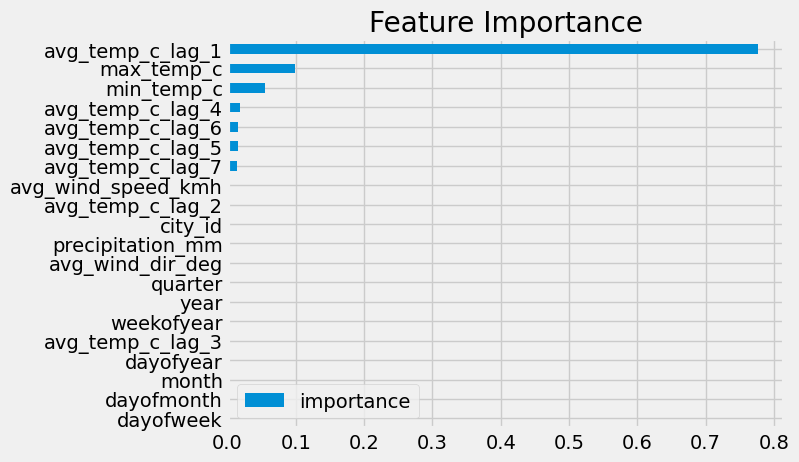

In [362]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [363]:
# feature_importances = reg.best_estimator_.feature_importances_
# feature_names = reg.best_estimator_.feature_names_in_
# fi = pd.DataFrame(data=feature_importances,
#                   index=feature_names,
#                   columns=['importance'])
# fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
# plt.show()

In [364]:
# ll=[]
# ll.append(np.abs(y_test - xgb_cv.predict(X_test)))
# ll


In [365]:
# lr = LinearRegression()

In [366]:
# lr.fit(X_train, y_train)

In [367]:
# y_pred_lr = lr.predict(X_test)

In [368]:
# np.sqrt(mean_squared_error(y_test, y_pred_lr))